# Grid Search to Find Good Solution for 0.5 Msun

In [1]:
# Imports
import numpy as np
from astropy.table import Table
import matplotlib.pyplot as plt
from starmodel2 import starmodel
import matplotlib.colors as colors
from scipy.optimize import curve_fit
%matplotlib inline

In [2]:
Msun = 1.989e33
Lsun = 3.826e33

In [3]:
 def gridsearch(pars,lumrange,teffrange,nlum=10,nteff=10,verbose=False):
    """
    Run a grid search of starmodel.
    
    Parameters
    ----------
    pars : list
       List with total stellar mass, X and Z.
    lumrange : list
       List with luminosity range to search, minimum and maximum.
    teffrange : list
       List with temperature range to search, minimum and maximum.
    nlum : int
       Number of luminosity points to search.  Default is 10.
    nteff : int
       Number of temperature points to search.  Default is 10.
    
    Returns
    -------
    data : dict
       Dictionary with all of the information
       
    Example
    -------
    
    data = gridsearch([1.0,0.70,0.08],[0.8,1.2],0.02,[5000.0,6000.0],50)
    
    """
    # pars should be [total mass, X, Z]
    totmass = pars[0]
    X = pars[1]
    Z = pars[2]
    """ Search a grid in Luminosity and Teff"""
    luminosity = np.linspace(lumrange[0],lumrange[1],nlum,endpoint=True)
    temperature = np.linspace(teffrange[0],teffrange[1],nteff,endpoint=True)
    print('Search grid is ',len(luminosity),' x ',len(temperature))
    igoof = np.zeros((len(luminosity),len(temperature)),int)
    mass0 = np.zeros((len(luminosity),len(temperature)),float)
    lum0 = np.zeros((len(luminosity),len(temperature)),float)
    temp0 = np.zeros((len(luminosity),len(temperature)),float)
    dtemp0 = np.zeros((len(luminosity),len(temperature)),float)
    drho0 = np.zeros((len(luminosity),len(temperature)),float)
    deps0 = np.zeros((len(luminosity),len(temperature)),float)
    # criteria:
    # 1: mass0 >0
    # 2: mass0 < 0.01*Mstar
    # 3: lum0 >0
    # 4: lum0 < 0.1*Lstar
    # 5: Tcore > Tshell2
    # 6: rhocore > rhoshell2
    # 7: epsiloncore > epsilonshell2
    criteria = np.zeros((len(luminosity),len(temperature),7),bool)
    for i,lum in enumerate(luminosity):
        for j,teff in enumerate(temperature):
            Igoof,ierr,istop,tab = starmodel(totmass,lum,teff,X,Z,verbose=False)
            igoof[i,j] = Igoof
            mass0[i,j] = tab['M'][-1]  # central shell
            lum0[i,j] = tab['L'][-1]   # central shell
            temp0[i,j] = tab['T'][-1]  # central shell
            dtemp0[i,j] = tab['T'][-1]-tab['T'][-2]
            drho0[i,j] = tab['rho'][-1]-tab['rho'][-2]
            deps0[i,j] = tab['epsilon'][-1]-tab['epsilon'][-2]
            criteria[i,j,0] = tab['M'][-1] > 0
            criteria[i,j,1] = tab['M'][-1] < 0.01*tab['M'][0]
            criteria[i,j,2] = tab['L'][-1] > 0
            criteria[i,j,3] = tab['L'][-1] < 0.1*tab['L'][0]
            criteria[i,j,4] = dtemp0[i,j] > 0
            criteria[i,j,5] = drho0[i,j] > 0
            criteria[i,j,6] = deps0[i,j] > 0

            if verbose:
                print(lum,teff,Igoof,mass0[i,j],lum0[i,j],temp0[i,j])
    
    data = {'pars':pars,'luminosity':luminosity,'temperature':temperature,'igoof':igoof,
            'mass0':mass0,'lum0':lum0,'temp0':temp0,'dtemp0':dtemp0,'drho0':drho0,
            'deps0':deps0,'criteria':criteria}
    return data

In [40]:
def analyzeresults(data):
    """ Analyze the grid results """
    
    pars = data['pars']
    luminosity = data['luminosity']
    temperature = data['temperature']
    mass0 = data['mass0']
    lum0 = data['lum0']
    temp0 = data['temp0']
    igoof = data['igoof']
    criteria = data['criteria']
        
    fig,axs = plt.subplots(5,1,figsize=(8,25))
        
    # Mass results
    print('Mass results')
    print('------------')
    print('Min M0=',np.min(mass0))
    print('Max M0=',np.max(mass0))
    print('Min |M0|=',np.min(np.abs(mass0)))
    bestind = np.unravel_index(np.argmin(np.abs(mass0), axis=None), mass0.shape)
    bestlum = luminosity[bestind[0]]
    bestteff = temperature[bestind[1]]
    print('Best index = ',bestind)
    print('Best Luminosity=',luminosity[bestind[0]])
    print('Best Temperature=',temperature[bestind[1]])
    print(' ')
    im1 = axs[0].imshow(mass0,extent=[temperature[0],temperature[-1],luminosity[0],luminosity[-1]],
               origin='lower',aspect='auto')
    axs[0].scatter(temperature[bestind[1]],luminosity[bestind[0]],c='r',marker='+',s=200)
    plt.colorbar(im1, ax=axs[0])

    # Luminosity results
    print('Luminosity results')
    print('------------')
    print('Min M0=',np.min(lum0))
    print('Max M0=',np.max(lum0))
    print('Min |M0|=',np.min(np.abs(lum0)))
    bestind = np.unravel_index(np.argmin(np.abs(lum0), axis=None), mass0.shape)
    bestlum = luminosity[bestind[0]]
    bestteff = temperature[bestind[1]]
    print('Best index = ',bestind)
    print('Best Luminosity=',luminosity[bestind[0]])
    print('Best Temperature=',temperature[bestind[1]])
    print(' ')
    im1 = axs[1].imshow(lum0,extent=[temperature[0],temperature[-1],luminosity[0],luminosity[-1]],
               origin='lower',aspect='auto')
    axs[1].scatter(temperature[bestind[1]],luminosity[bestind[0]],c='r',marker='+',s=200)
    plt.colorbar(im1, ax=axs[1])
    
    # Mass * Luminosity
    bestind = np.unravel_index(np.argmin(np.abs(mass0)/pars[0]*np.abs(lum0)/np.max(lum0), axis=None), mass0.shape)
    bestlum = luminosity[bestind[0]]
    bestteff = temperature[bestind[1]]
    print('Best index = ',bestind)
    print('Best Luminosity=',luminosity[bestind[0]])
    print('Best Temperature=',temperature[bestind[1]])
    im2 = axs[2].imshow(np.abs(mass0)*np.abs(lum0),extent=[temperature[0],temperature[-1],luminosity[0],luminosity[-1]],
                   origin='lower',aspect='auto')
    axs[2].scatter(temperature[bestind[1]],luminosity[bestind[0]],c='r',marker='+',s=200)
    plt.colorbar(im1, ax=axs[2])
    
    
    Igoof,ierr,istop,tab = starmodel(pars[0],bestlum,bestteff,pars[1],pars[2],verbose=False)
    
    # Mass versus radius
    axs[3].plot(tab['r'],tab['M'])

    # Luminosity versus radius
    axs[4].plot(tab['r'],tab['L'])
    
    fig,axs = plt.subplots(9,1,figsize=(8,35))
    axs[0].imshow(criteria[:,:,0],extent=[temperature[0],temperature[-1],luminosity[0],luminosity[-1]],
               origin='lower',aspect='auto',vmin=0,vmax=1)
    axs[0].set_title('Mcore>0')
    axs[1].imshow(criteria[:,:,1],extent=[temperature[0],temperature[-1],luminosity[0],luminosity[-1]],
               origin='lower',aspect='auto',vmin=0,vmax=1)
    axs[1].set_title('Mcore<0.01*Mstar') 
    axs[2].imshow(criteria[:,:,2],extent=[temperature[0],temperature[-1],luminosity[0],luminosity[-1]],
               origin='lower',aspect='auto',vmin=0,vmax=1)
    axs[2].set_title('Lcore>0') 
    axs[3].imshow(criteria[:,:,3],extent=[temperature[0],temperature[-1],luminosity[0],luminosity[-1]],
               origin='lower',aspect='auto',vmin=0,vmax=1)
    axs[3].set_title('Lcore<0.1*Lstar') 
    axs[4].imshow(criteria[:,:,4],extent=[temperature[0],temperature[-1],luminosity[0],luminosity[-1]],
               origin='lower',aspect='auto',vmin=0,vmax=1)
    axs[4].set_title('dTemp_core>0') 
    axs[5].imshow(criteria[:,:,5],extent=[temperature[0],temperature[-1],luminosity[0],luminosity[-1]],
               origin='lower',aspect='auto',vmin=0,vmax=1)
    axs[5].set_title('drho_core>0') 
    axs[6].imshow(criteria[:,:,6],extent=[temperature[0],temperature[-1],luminosity[0],luminosity[-1]],
               origin='lower',aspect='auto',vmin=0,vmax=1)
    axs[6].set_title('deps_core>0') 
    allcriteria = criteria[:,:,0] * criteria[:,:,1] * criteria[:,:,2] * criteria[:,:,3] * criteria[:,:,4] * criteria[:,:,5] * criteria[:,:,6] 
    axs[7].imshow(allcriteria,extent=[temperature[0],temperature[-1],luminosity[0],luminosity[-1]],
               origin='lower',aspect='auto',vmin=0,vmax=1)
    axs[7].set_title('All Criteria') 
    
    axs[8].imshow(igoof,extent=[temperature[0],temperature[-1],luminosity[0],luminosity[-1]],
               origin='lower',aspect='auto')
    axs[8].set_title('igoof')
    ind = np.where(igoof==0)
    print('igoof=0',ind[0].size)
    if np.sum(ind)>0:
        print(luminosity[ind[0]])
        print(temperature[ind[1]])

In [5]:
def crossing(arr):
    """ Find points where the values cross from positive to negative or vice versa"""
    line1 = np.abs(np.gradient(np.sign(arr),axis=1)).astype(int)
    line2 = np.abs(np.gradient(np.sign(arr),axis=0)).astype(int)
    line = line1 | line2
    return line

In [42]:
#data = gridsearch([0.8,0.70,0.008],[0.2175,0.220],[3720,3730],nlum=70,nteff=70)
#data = gridsearch([0.8,0.70,0.008],[0.16,0.30],[3700,4300],nlum=120,nteff=120)
# 0.27155462,4212.18487
# 0.27155
# 0.271512605, 4214.234453
data = gridsearch([0.5,0.70,0.008],[0.10,0.23],[2500,3100],nlum=120,nteff=120)

Search grid is  120  x  120
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  509
 with the following conditions:
T =  -23312810.007502757  K
P =  9.77230653049357e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  508
 with the following conditions:
T =  -4.70456859788643e+16  K
P =  3.808225757661107e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with di

 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  504
 with the following conditions:
T =  -9.307650344507258e+19  K
P =  5.222788669618033e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  504
 with the following conditions:
T =  -2752989.0218534023  K
P =  6.212173172166381e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial condition

 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  507
 with the following conditions:
T =  -26189120.48056663  K
P =  8.432253064092268e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  507
 with the following conditions:
T =  -41092223.60414947  K
P =  8.746517228930758e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 I

 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  508
 with the following conditions:
T =  -41911208.07622157  K
P =  9.503061524217718e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  508
 with the following conditions:
T =  -64811101.89963112  K
P =  9.890458834539363e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 I

 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  508
 with the following conditions:
T =  -458040289.2074423  K
P =  1.209717323997525e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  508
 with the following conditions:
T =  -1012399661.1931216  K
P =  1.3145276206927903e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.


 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  499
 with the following conditions:
T =  -20108274.24575053  K
P =  3.4449520418869914e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  499
 with the following conditions:
T =  -66002152.749732316  K
P =  3.5536791067923757e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.

 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  501
 with the following conditions:
T =  -63130423.90649505  K
P =  3.764963088022354e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  501
 with the following conditions:
T =  -239274700.49167442  K
P =  3.921976740419748e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 

 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  506
 with the following conditions:
T =  -23844300.115747686  K
P =  4.2773089911426035e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  506
 with the following conditions:
T =  -60662304.88789583  K
P =  4.4133300435905894e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.

 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  513
 with the following conditions:
T =  -1163404.9087822586  K
P =  5.398350988842879e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  513
 with the following conditions:
T =  -5959394.904600512  K
P =  5.522077323874984e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 

 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  506
 with the following conditions:
T =  -1355956561.8285213  K
P =  4.977469692656921e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  506
 with the following conditions:
T =  -18005920014.352966  K
P =  5.533239360887699e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.


 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  514
 with the following conditions:
T =  -114242234.86240645  K
P =  6.624281057442537e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  513
 with the following conditions:
T =  -3564647.8914574627  K
P =  5.479039517494485e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.


 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  509
 with the following conditions:
T =  -40837440.48096253  K
P =  4.9105548447472384e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  509
 with the following conditions:
T =  -96353722.3787823  K
P =  5.0827969118018e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In 

 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  517
 with the following conditions:
T =  -38215023694.365974  K
P =  1.189492614350984e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  516
 with the following conditions:
T =  -91135647.89093982  K
P =  7.483184566823048e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 

 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  512
 with the following conditions:
T =  -626058766.1479362  K
P =  6.436725531933792e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  512
 with the following conditions:
T =  -2724443502.1101317  K
P =  6.924855992332005e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 

 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  508
 with the following conditions:
T =  -9.953570424295538e+17  K
P =  2.2351470425716262e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  508
 with the following conditions:
T =  -2591007.841876924  K
P =  5.153093413826341e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial condition

 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  515
 with the following conditions:
T =  -10045593010.730104  K
P =  9.178568490982514e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  515
 with the following conditions:
T =  -125820776481.34288  K
P =  1.0757621293994511e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.

 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  510
 with the following conditions:
T =  -19409710840.41879  K
P =  6.832227637816287e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  510
 with the following conditions:
T =  -1312532179402.4294  K
P =  8.646322750359895e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 

 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  517
 with the following conditions:
T =  -1153987.0998483729  K
P =  8.371488565677635e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  517
 with the following conditions:
T =  -4152664.007184306  K
P =  8.580291202276897e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 

 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  513
 with the following conditions:
T =  -5631297.98372137  K
P =  6.708617881640603e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  513
 with the following conditions:
T =  -10677233.344001753  K
P =  6.898031729879094e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 I

 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  518
 with the following conditions:
T =  -20279816.46996267  K
P =  1.0106889008761238e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  518
 with the following conditions:
T =  -29697443.3313687  K
P =  1.0426697035769482e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 

 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  513
 with the following conditions:
T =  -13806658.475797096  K
P =  7.01921029733878e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  513
 with the following conditions:
T =  -22517498.217985548  K
P =  7.24399972927688e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 I

 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  518
 with the following conditions:
T =  -120765845.5051373  K
P =  1.1993973749124099e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  518
 with the following conditions:
T =  -190482756.83102018  K
P =  1.2593145926688988e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.

 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  514
 with the following conditions:
T =  -126198292.6808393  K
P =  8.940048020196224e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  513
 with the following conditions:
T =  -17528065.631333493  K
P =  7.146075139696338e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 

 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  518
 with the following conditions:
T =  -1940970964.3009787  K
P =  1.6273939317036e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  517
 with the following conditions:
T =  -91175156.06308937  K
P =  1.0759447367392244e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 I

T =  -9388165858.05334  K
P =  2.389607611711063e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  520
 with the following conditions:
T =  -36635200529.20144  K
P =  2.789128035172549e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  520
 with the following conditions:
T =  -250787080407.34866  K
P =  3.4694845264177336e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contrac

 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  506
 with the following conditions:
T =  -6325686.076729931  K
P =  3.453236713037214e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  506
 with the following conditions:
T =  -21582934.224874035  K
P =  3.5386157963844166e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.


 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  510
 with the following conditions:
T =  -930771.3526173513  K
P =  3.7317284018411e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  509
 with the following conditions:
T =  -2003229.7480684426  K
P =  3.664473280650564e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In

P =  4.01688107660527e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  509
 with the following conditions:
T =  -441097965.6457217  K
P =  4.1979413350759475e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  508
 with the following conditions:
T =  -53002147.08694011  K
P =  3.8374195496428883e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try aga

 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  515
 with the following conditions:
T =  -400638.4214156307  K
P =  4.286219648426015e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  514
 with the following conditions:
T =  -3007201.950778894  K
P =  4.209636650479744e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 I

 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  526
 with the following conditions:
T =  -12302475.603371777  K
P =  7.389969704584524e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  526
 with the following conditions:
T =  -20533668.160702094  K
P =  7.574044185076036e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.


 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  514
 with the following conditions:
T =  -5332771.627639819  K
P =  4.25657777320028e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  514
 with the following conditions:
T =  -15239036.280500988  K
P =  4.3586914449446016e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 

 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  526
 with the following conditions:
T =  -226084604.97641754  K
P =  8.79599762217343e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  526
 with the following conditions:
T =  -456606480.75182194  K
P =  9.206656334085304e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 

 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  520
 with the following conditions:
T =  -5200818.322557922  K
P =  5.2532562245173357e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  520
 with the following conditions:
T =  -12508874.574848035  K
P =  5.377338897563546e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.


 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  514
 with the following conditions:
T =  -8226069.034413416  K
P =  4.305225244804148e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  514
 with the following conditions:
T =  -20907870.341274597  K
P =  4.412800429775303e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 

 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  527
 with the following conditions:
T =  -974284426133.092  K
P =  1.7424618021285573e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  526
 with the following conditions:
T =  -179689039.9860036  K
P =  8.679666579477263e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 I

 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  522
 with the following conditions:
T =  -45820158.53034012  K
P =  6.246437599324998e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  522
 with the following conditions:
T =  -86117044.66477859  K
P =  6.449004041799343e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 I

 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  518
 with the following conditions:
T =  -50608538.32025016  K
P =  5.239981949041971e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  518
 with the following conditions:
T =  -111441514.63921335  K
P =  5.419472985600944e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 

 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  514
 with the following conditions:
T =  -4151469518.7662106  K
P =  5.3999525078226643e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  514
 with the following conditions:
T =  -94845919827.85133  K
P =  6.192467848572698e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.


 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  525
 with the following conditions:
T =  -574888508.2985233  K
P =  8.68432256396557e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  525
 with the following conditions:
T =  -1527020651.3799546  K
P =  9.222286781424294e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 I

 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  520
 with the following conditions:
T =  -25048990.46936397  K
P =  5.542637039130137e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  520
 with the following conditions:
T =  -48534682.296321005  K
P =  5.702897313258629e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 

 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  516
 with the following conditions:
T =  -5853611024.707534  K
P =  5.943418439453704e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  516
 with the following conditions:
T =  -131348566510.73203  K
P =  6.88771857984538e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 I

 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  527
 with the following conditions:
T =  -6576831.434273673  K
P =  9.77891459346622e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  527
 with the following conditions:
T =  -10785792.145433208  K
P =  1.0032310022530737e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 

 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  522
 with the following conditions:
T =  -1302467253.5810688  K
P =  7.478099935455789e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  522
 with the following conditions:
T =  -5778942926.884004  K
P =  8.107871202701257e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 

 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  518
 with the following conditions:
T =  -4087745032.8807373  K
P =  6.407976476083965e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  518
 with the following conditions:
T =  -51908149417.88707  K
P =  7.261544553105435e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 

 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  528
 with the following conditions:
T =  -15813979.576789172  K
P =  1.1167677297881377e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  528
 with the following conditions:
T =  -22589851.865481853  K
P =  1.1484213600638798e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions

 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  524
 with the following conditions:
T =  -5726047.361843703  K
P =  7.94348051515625e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  523
 with the following conditions:
T =  -12668495038.19592  K
P =  9.084430775739867e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In

 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  519
 with the following conditions:
T =  -161732415822913.84  K
P =  1.30183588548312e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  519
 with the following conditions:
T =  -846361.6865853406  K
P =  5.930919955592033e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 I

 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  529
 with the following conditions:
T =  -189538504.36265934  K
P =  1.5740700445541215e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  529
 with the following conditions:
T =  -286874708.07395536  K
P =  1.6523835579228088e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions

 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  524
 with the following conditions:
T =  -13044534.692806527  K
P =  8.294010318565542e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  524
 with the following conditions:
T =  -20014732.152017944  K
P =  8.535818894793004e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.


 In case it helps, I detected the problem in zone  520
 with the following conditions:
T =  -18237699.28781335  K
P =  6.827361149717719e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  519
 with the following conditions:
T =  -6.726779114849576e+17  K
P =  2.747542586437569e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  519
 with the following conditions:
T =  -2120212.564630851  K
P =  6.010587165805645e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either 

 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  528
 with the following conditions:
T =  -94446101.47645071  K
P =  1.3282313246463283e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  528
 with the following conditions:
T =  -136870782.77806133  K
P =  1.3841117658606356e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.

 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  524
 with the following conditions:
T =  -24839633.514098935  K
P =  8.697237681316739e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  524
 with the following conditions:
T =  -36779278.71527266  K
P =  8.983143105483246e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 

 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  520
 with the following conditions:
T =  -22456560.080369562  K
P =  6.943059480906799e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  520
 with the following conditions:
T =  -35366113.83554838  K
P =  7.178911000083884e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 

T =  -1475227380.5112772  K
P =  1.8189982049120026e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  527
 with the following conditions:
T =  -77679401.24198551  K
P =  1.1981667556617836e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  527
 with the following conditions:
T =  -113174294.41447766  K
P =  1.247216073881834e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 cont

 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  523
 with the following conditions:
T =  -20940780.481469005  K
P =  8.106401703459448e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  523
 with the following conditions:
T =  -31545201.250859812  K
P =  8.36649164974762e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 

 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  531
 with the following conditions:
T =  -1412957772261.9119  K
P =  5.69248551801341e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  531
 with the following conditions:
T =  -43022351220180.086  K
P =  8.489358519648599e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 

 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  526
 with the following conditions:
T =  -259517170.49366346  K
P =  1.262830295660853e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  526
 with the following conditions:
T =  -445939987.3354258  K
P =  1.3393245123292334e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.


 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  521
 with the following conditions:
T =  -57817190.20212917  K
P =  7.906348356291366e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  521
 with the following conditions:
T =  -92653564.31718339  K
P =  8.24561881473075e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In

 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  525
 with the following conditions:
T =  -292457079.1512431  K
P =  1.1890753891785398e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  525
 with the following conditions:
T =  -528588829.5526503  K
P =  1.2661802358902052e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.


 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  513
 with the following conditions:
T =  -24706639.444242433  K
P =  3.703222442206768e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  515
 with the following conditions:
T =  -6181825.254115662  K
P =  3.73514792616789e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 I

 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  515
 with the following conditions:
T =  -30493335.99992099  K
P =  3.894396519460014e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  515
 with the following conditions:
T =  -82846874.93902054  K
P =  4.009844218446054e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 I

 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  515
 with the following conditions:
T =  -394821097.42886525  K
P =  4.222034231351361e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  536
 with the following conditions:
T =  -21607483.712387748  K
P =  8.354808338563704e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.


 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  517
 with the following conditions:
T =  -18500780.56261807  K
P =  4.017825606584736e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  517
 with the following conditions:
T =  -46263247.785983115  K
P =  4.125218304001404e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 

 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  534
 with the following conditions:
T =  -1974316.910909135  K
P =  6.814068230195002e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  534
 with the following conditions:
T =  -5762214.845835423  K
P =  6.959858361679508e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 I

 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  517
 with the following conditions:
T =  -691219823.0582491  K
P =  4.5191623776268045e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  517
 with the following conditions:
T =  -5437224861.570392  K
P =  4.851879473581507e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 

 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  533
 with the following conditions:
T =  -2315559.081497362  K
P =  6.48050811759713e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  533
 with the following conditions:
T =  -6448416.565165153  K
P =  6.619950673955348e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In

 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  519
 with the following conditions:
T =  -1683759776.6617522  K
P =  4.913918109568444e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  518
 with the following conditions:
T =  -35557916.31027117  K
P =  4.204374541845581e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 

 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  535
 with the following conditions:
T =  -819202727.96329  K
P =  9.908682583593934e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  534
 with the following conditions:
T =  -21022946.322416767  K
P =  7.350911628944425e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In

 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  529
 with the following conditions:
T =  -2089930.2673373837  K
P =  5.424877085211264e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  528
 with the following conditions:
T =  -2313977.681225527  K
P =  5.232086851902075e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 

 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  520
 with the following conditions:
T =  -217376815.03944227  K
P =  4.70122607478047e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  520
 with the following conditions:
T =  -820768836.9610643  K
P =  4.9332781704290566e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 

 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  536
 with the following conditions:
T =  -3034549326.1360755  K
P =  1.1795202173572342e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  536
 with the following conditions:
T =  -10301420223.667717  K
P =  1.285125715756139e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.

 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  532
 with the following conditions:
T =  -118271628.02809764  K
P =  7.233878440230871e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  531
 with the following conditions:
T =  -3131630.2994542606  K
P =  5.93494405191821e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 

 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  526
 with the following conditions:
T =  -3580032.2118732594  K
P =  4.92677465672382e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  526
 with the following conditions:
T =  -10108675.032268316  K
P =  5.0355632689833126e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.


 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  521
 with the following conditions:
T =  -29086675.222135544  K
P =  4.5061513889734957e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  521
 with the following conditions:
T =  -66342844.08806261  K
P =  4.636012352913699e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.


 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  538
 with the following conditions:
T =  -21345378.977934882  K
P =  1.285398232623419e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  538
 with the following conditions:
T =  -29013823.867976673  K
P =  1.3214664525178527e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.

 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  534
 with the following conditions:
T =  -31549781205.906662  K
P =  1.166183468263582e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  533
 with the following conditions:
T =  -86921822.49545857  K
P =  7.533981255318203e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 

 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  529
 with the following conditions:
T =  -51582038.59687799  K
P =  6.004527772239373e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  529
 with the following conditions:
T =  -98369625.03824882  K
P =  6.194914578508659e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 I

 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  525
 with the following conditions:
T =  -49958636.573161565  K
P =  5.1676620846876486e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  525
 with the following conditions:
T =  -107451704.50082819  K
P =  5.333508969499123e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.

 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  521
 with the following conditions:
T =  -1348489.287362961  K
P =  4.977759472549151e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  520
 with the following conditions:
T =  -2684552151.613494  K
P =  5.1864937317390246e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 

 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  535
 with the following conditions:
T =  -227607967578.02124  K
P =  1.466018642524886e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  535
 with the following conditions:
T =  -8477042728799.733  K
P =  1.9484806949817329e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.


 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  531
 with the following conditions:
T =  -171926819.74292263  K
P =  7.027628428995685e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  531
 with the following conditions:
T =  -367372986.7464922  K
P =  7.324937965805508e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 

 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  527
 with the following conditions:
T =  -53234004.826653756  K
P =  5.5671272373066374e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  527
 with the following conditions:
T =  -108184845.40801601  K
P =  5.746439133085488e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.

 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  523
 with the following conditions:
T =  -174407061.1548462  K
P =  5.115013458936749e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  523
 with the following conditions:
T =  -527185889.50321484  K
P =  5.345726360100855e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 

 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  539
 with the following conditions:
T =  -241484156.07108513  K
P =  1.8532837143005558e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  539
 with the following conditions:
T =  -354995479.3072555  K
P =  1.9431849698512072e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.

 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  534
 with the following conditions:
T =  -6.086467636282136e+26  K
P =  5.2716199717627445e+19  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  534
 with the following conditions:
T =  -2347346.2686518226  K
P =  8.62090264266371e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial condition

 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  530
 with the following conditions:
T =  -5971670034.095278  K
P =  8.077622458950447e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  530
 with the following conditions:
T =  -48631527265.16785  K
P =  9.08926313301472e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In

 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  525
 with the following conditions:
T =  -693701496.0249298  K
P =  5.804228226322629e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  525
 with the following conditions:
T =  -3114578995.923433  K
P =  6.198098797446753e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 I

 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  540
 with the following conditions:
T =  -1042215612.7988542  K
P =  2.4845297346377974e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  540
 with the following conditions:
T =  -1800121727.6404114  K
P =  2.6588041171915284e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions

 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  535
 with the following conditions:
T =  -1631534.7298236825  K
P =  9.150700210205399e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  535
 with the following conditions:
T =  -4392661.662454287  K
P =  9.363148055002333e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 

 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  531
 with the following conditions:
T =  -41471177243111.73  K
P =  1.553936890792258e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  531
 with the following conditions:
T =  -2.1480758180009342e+31  K
P =  1.2974901477941407e+20  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditio

 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  526
 with the following conditions:
T =  -1521509647.854394  K
P =  6.259180523448192e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  526
 with the following conditions:
T =  -9013859998.712622  K
P =  6.797808341596285e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 I

 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  541
 with the following conditions:
T =  -699910642929767.6  K
P =  1.4083057998813327e+19  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  541
 with the following conditions:
T =  -2.3637234446140018e+20  K
P =  6.340691320304748e+19  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditio

 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  536
 with the following conditions:
T =  -48231548.15147635  K
P =  1.1868237995891338e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  536
 with the following conditions:
T =  -66836702.25602728  K
P =  1.2274610602392573e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.


 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  531
 with the following conditions:
T =  -2435203690181.318  K
P =  1.257347200677291e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  531
 with the following conditions:
T =  -1.323716599923103e+16  K
P =  2.578657265957924e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions

 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  526
 with the following conditions:
T =  -1052974960044.0996  K
P =  8.790530986145934e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  526
 with the following conditions:
T =  -2.127702904208702e+16  K
P =  1.8547777300581796e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditio

 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  540
 with the following conditions:
T =  -26258260660.722622  K
P =  3.688200655811163e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  540
 with the following conditions:
T =  -95526229442.28955  K
P =  4.298809913010159e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 

 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  535
 with the following conditions:
T =  -27109963.647974543  K
P =  1.0478017379513912e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  535
 with the following conditions:
T =  -37873198.13711478  K
P =  1.0798716542853111e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.

 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  531
 with the following conditions:
T =  -16134962.220627477  K
P =  7.94340168108859e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  530
 with the following conditions:
T =  -39912912767964.336  K
P =  1.4437997612303862e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.


 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  526
 with the following conditions:
T =  -2956019.258927021  K
P =  5.971847009426268e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  526
 with the following conditions:
T =  -6749875.676568346  K
P =  6.119029937301358e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 I

 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  538
 with the following conditions:
T =  -630996660.7733352  K
P =  1.8957390482652513e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  538
 with the following conditions:
T =  -1080779692.3392317  K
P =  2.0211192898296195e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.

 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  534
 with the following conditions:
T =  -95304704.83122423  K
P =  1.107888701852556e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  533
 with the following conditions:
T =  -11532680.396796236  K
P =  8.691371763544261e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 

 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  529
 with the following conditions:
T =  -9241947.2124222  K
P =  7.01326375163376e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  529
 with the following conditions:
T =  -15011652.02103968  K
P =  7.20339648783894e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In ca

 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  540
 with the following conditions:
T =  -20110041401176.22  K
P =  8.086573006048518e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  540
 with the following conditions:
T =  -5478582613728610.0  K
P =  1.562638780142732e+19  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 

 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  535
 with the following conditions:
T =  -79132889.62930563  K
P =  1.1666820415971878e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  535
 with the following conditions:
T =  -114013822.30950613  K
P =  1.2128687967247805e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.

 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  531
 with the following conditions:
T =  -79767895.29058903  K
P =  9.108149440703645e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  530
 with the following conditions:
T =  -10517189.51322363  K
P =  7.405968246047668e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 I

 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  540
 with the following conditions:
T =  -1.0038095582275623e+20  K
P =  4.982698580013094e+19  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  540
 with the following conditions:
T =  -1420700.3337679338  K
P =  9.194579057524884e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditio

 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  535
 with the following conditions:
T =  -2385713187.53719  K
P =  1.6999437186354606e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  534
 with the following conditions:
T =  -99837929.94758597  K
P =  1.1177747185744275e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 

 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  530
 with the following conditions:
T =  -106707504.00587824  K
P =  8.904887706905101e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  530
 with the following conditions:
T =  -173990922.66666055  K
P =  9.332593243675793e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.


 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  535
 with the following conditions:
T =  -3957898394.1683636  K
P =  1.801308022318542e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  535
 with the following conditions:
T =  -11859706046.32747  K
P =  2.0323274516607657e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.


 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  530
 with the following conditions:
T =  -225152673.71742085  K
P =  9.593898569131053e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  529
 with the following conditions:
T =  -63437814.27205566  K
P =  8.104911415737108e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 

 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  535
 with the following conditions:
T =  -13735564337.711853  K
P =  2.074532407138174e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  534
 with the following conditions:
T =  -2353626348.336167  K
P =  1.581406371102671e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 

 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  547
 with the following conditions:
T =  -4671638191.4713955  K
P =  1.522018848129374e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  547
 with the following conditions:
T =  -14211033516.88172  K
P =  1.6606026621442266e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.


 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  546
 with the following conditions:
T =  -219002238.56644452  K
P =  1.0925974340974802e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  546
 with the following conditions:
T =  -368294400.5966238  K
P =  1.1366433677867382e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.

 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  546
 with the following conditions:
T =  -6410027875.902514  K
P =  1.4079709364215695e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  545
 with the following conditions:
T =  -53276606.16130994  K
P =  9.112677077154401e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 

 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  546
 with the following conditions:
T =  -4458345632.627028  K
P =  1.372083339191247e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  546
 with the following conditions:
T =  -14349739009.708645  K
P =  1.4972925674986586e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.


 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  541
 with the following conditions:
T =  -1316998.253190728  K
P =  6.363570806050373e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  527
 with the following conditions:
T =  -1994379.805971887  K
P =  4.2337963438111155e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 

 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  544
 with the following conditions:
T =  -330475065.40379703  K
P =  9.65742442031389e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  544
 with the following conditions:
T =  -639339537.1553857  K
P =  1.0098921726525512e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 

 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  548
 with the following conditions:
T =  -35789809.96162541  K
P =  1.5243171851991409e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  547
 with the following conditions:
T =  -4.9489192240559136e+17  K
P =  8.662071287111049e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditio

 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  543
 with the following conditions:
T =  -151305225.4076997  K
P =  8.5857343874567e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  543
 with the following conditions:
T =  -267019881.7348912  K
P =  8.907881538631402e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In 

 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  549
 with the following conditions:
T =  -145750518.96678358  K
P =  1.990513285658316e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  549
 with the following conditions:
T =  -196500450.27882177  K
P =  2.0679933372915968e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.

 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  544
 with the following conditions:
T =  -5061912367.958709  K
P =  1.1640857328790295e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  544
 with the following conditions:
T =  -19821564542.164032  K
P =  1.2782647462868416e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.

 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  539
 with the following conditions:
T =  -2935648.444631802  K
P =  5.934908718482655e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  539
 with the following conditions:
T =  -7676551.710225444  K
P =  6.059296256127101e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 I

 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  549
 with the following conditions:
T =  -178020020.9963635  K
P =  2.0443866897531448e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  549
 with the following conditions:
T =  -243357852.87006965  K
P =  2.1280959483893112e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.

 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  544
 with the following conditions:
T =  -3331097002.492063  K
P =  1.1332091777232535e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  544
 with the following conditions:
T =  -11328412059.593702  K
P =  1.2315760068306038e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.

 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  540
 with the following conditions:
T =  -91818406.43858264  K
P =  7.092844366581409e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  539
 with the following conditions:
T =  -1355264.8403979354  K
P =  5.893004050056394e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 

 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  532
 with the following conditions:
T =  -102360.67739242688  K
P =  4.7183684649050906e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  532
 with the following conditions:
T =  -4607578.458254091  K
P =  4.812181645236207e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.


 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  550
 with the following conditions:
T =  -8718074103.303385  K
P =  3.780574384267725e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  550
 with the following conditions:
T =  -20563099625.222534  K
P =  4.2013887062674156e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.


 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  545
 with the following conditions:
T =  -5868891.453210006  K
P =  1.0528271401347151e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  544
 with the following conditions:
T =  -6893614258.692285  K
P =  1.1921362898321528e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.


 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  540
 with the following conditions:
T =  -72589058.36686696  K
P =  7.01256649328041e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  540
 with the following conditions:
T =  -127613579.51626198  K
P =  7.23612627933116e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In

 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  535
 with the following conditions:
T =  -1505895.234481385  K
P =  5.163123082806034e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  535
 with the following conditions:
T =  -6303891.377638269  K
P =  5.2685693754044576e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 

 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  530
 with the following conditions:
T =  -12633428.377699945  K
P =  4.699657915838722e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  530
 with the following conditions:
T =  -27005836.790469695  K
P =  4.810275282587364e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.


 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  548
 with the following conditions:
T =  -96232040.1080167  K
P =  1.7146278000199332e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  548
 with the following conditions:
T =  -128454513.64451703  K
P =  1.7762212751127327e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.


 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  544
 with the following conditions:
T =  -4832426.44717839  K
P =  9.787904478884111e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  543
 with the following conditions:
T =  -5148946602.929451  K
P =  1.0840721609428485e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 I

 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  539
 with the following conditions:
T =  -213679127.1184741  K
P =  7.112545574520865e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  539
 with the following conditions:
T =  -460638616.2248028  K
P =  7.412820113982602e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 I

 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  534
 with the following conditions:
T =  -4549765.443351062  K
P =  5.093927664737438e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  534
 with the following conditions:
T =  -11263322.283287717  K
P =  5.2026169094665075e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.


 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  530
 with the following conditions:
T =  -77318605.55256243  K
P =  5.0086442414052646e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  530
 with the following conditions:
T =  -182172793.0800136  K
P =  5.176884296101907e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 

 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  548
 with the following conditions:
T =  -687864260.6680889  K
P =  2.19206094150976e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  547
 with the following conditions:
T =  -49458807.95598729  K
P =  1.452013617469782e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In

 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  543
 with the following conditions:
T =  -117378579998249.94  K
P =  2.320167971238223e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  543
 with the following conditions:
T =  -6.770194839383431e+22  K
P =  1.934495257977637e+19  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial condition

 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  538
 with the following conditions:
T =  -35207806.28123064  K
P =  6.223938879946179e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  538
 with the following conditions:
T =  -61494943.16255271  K
P =  6.394799067078926e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 I

 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  534
 with the following conditions:
T =  -117938605.25904708  K
P =  5.7139944747442656e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  534
 with the following conditions:
T =  -267656551.1955802  K
P =  5.925188948275726e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.


 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  530
 with the following conditions:
T =  -271508751.28816783  K
P =  5.270188759321311e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  530
 with the following conditions:
T =  -887154245.8772585  K
P =  5.520793999782005e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 

 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  547
 with the following conditions:
T =  -78519171.6407989  K
P =  1.5316170355171308e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  547
 with the following conditions:
T =  -105254284.42031223  K
P =  1.585148244257671e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 

 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  542
 with the following conditions:
T =  -13770522595.6866  K
P =  1.0786285484862881e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  542
 with the following conditions:
T =  -95617298703.64075  K
P =  1.2246822733068608e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 

 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  538
 with the following conditions:
T =  -827837414.1320357  K
P =  7.323485651481462e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  538
 with the following conditions:
T =  -2658173949.659863  K
P =  7.782001357908122e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 I

 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  534
 with the following conditions:
T =  -6427940750.862897  K
P =  6.856198713316109e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  534
 with the following conditions:
T =  -70712145689.18948  K
P =  7.715060269842588e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 I

 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  551
 with the following conditions:
T =  -2280857.3645639606  K
P =  1.1224131813615571e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  551
 with the following conditions:
T =  -4540711.222850647  K
P =  1.1460903944340332e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.

 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  546
 with the following conditions:
T =  -44576763.42330827  K
P =  1.3265506944568842e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  546
 with the following conditions:
T =  -59456947.87218214  K
P =  1.3679748785881426e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.


 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  542
 with the following conditions:
T =  -4494490.2766437605  K
P =  8.714107036398843e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  542
 with the following conditions:
T =  -7930932.47990215  K
P =  8.919356465768381e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 I

 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  538
 with the following conditions:
T =  -39781550354.34482  K
P =  9.036984594376416e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  538
 with the following conditions:
T =  -878450777174.4869  K
P =  1.0918280518699647e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 

 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  534
 with the following conditions:
T =  -16853579316.928122  K
P =  7.195311359231812e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  534
 with the following conditions:
T =  -351711854638.05664  K
P =  8.433618690688572e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.


 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  551
 with the following conditions:
T =  -6319500.940190541  K
P =  1.164094197235617e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  551
 with the following conditions:
T =  -9385055.754877245  K
P =  1.1899368130069484e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 

 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  546
 with the following conditions:
T =  -133345408.3831868  K
P =  1.5016530964857984e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  546
 with the following conditions:
T =  -187912884.45714602  K
P =  1.5634122703476728e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.

 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  542
 with the following conditions:
T =  -10318845.921900846  K
P =  9.060089589621684e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  542
 with the following conditions:
T =  -15378816.792169727  K
P =  9.290586231001047e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.


 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  538
 with the following conditions:
T =  -1913251.0762016922  K
P =  7.070870660121934e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  537
 with the following conditions:
T =  -2171400940.0622973  K
P =  7.384052932947453e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.


 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  533
 with the following conditions:
T =  -2608418410.7870135  K
P =  6.375996551369764e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  533
 with the following conditions:
T =  -18533305227.187054  K
P =  6.974479791270976e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.


 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  549
 with the following conditions:
T =  -140550459004.98044  K
P =  4.692388721864804e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  549
 with the following conditions:
T =  -828146693543.2108  K
P =  5.786900379335674e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 

 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  545
 with the following conditions:
T =  -234455257.38455516  K
P =  1.4834121774857946e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  544
 with the following conditions:
T =  -24987513.765637353  K
P =  1.0907371537610212e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions

 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  540
 with the following conditions:
T =  -223631.8549088277  K
P =  7.620348777123617e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  540
 with the following conditions:
T =  -2678021.4651438445  K
P =  7.787884439706926e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 

 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  536
 with the following conditions:
T =  -901411.285891084  K
P =  6.501769990551017e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  536
 with the following conditions:
T =  -3720779.74106087  K
P =  6.64771607319319e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In c

 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  531
 with the following conditions:
T =  -1410022.5757586695  K
P =  5.584300516359735e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  531
 with the following conditions:
T =  -4634967.912938915  K
P =  5.711568430527497e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 

 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  545
 with the following conditions:
T =  -99858756.2516987  K
P =  1.3478628112546373e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  545
 with the following conditions:
T =  -139843647.68406063  K
P =  1.400197081058801e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 

P =  8.443930612227512e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  541
 with the following conditions:
T =  -10985803.63463699  K
P =  8.64999978571233e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  541
 with the following conditions:
T =  -16386684.924397346  K
P =  8.872916957462679e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try agai

 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  537
 with the following conditions:
T =  -2.1321400897582743e+18  K
P =  3.599418995236361e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  537
 with the following conditions:
T =  -1817897.7357881293  K
P =  6.81624435628396e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial condition

 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  534
 with the following conditions:
T =  -22846784.810521632  K
P =  6.768441148971139e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  533
 with the following conditions:
T =  -665149.168361092  K
P =  5.889319182584133e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 I

 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  546
 with the following conditions:
T =  -616312665.7497119  K
P =  1.8081713447736392e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  546
 with the following conditions:
T =  -1040496418.7991849  K
P =  1.923398552231895e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.


 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  542
 with the following conditions:
T =  -77364753.29639699  K
P =  1.0768317521398712e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  542
 with the following conditions:
T =  -111610829.66122793  K
P =  1.118312136383875e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.


 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  538
 with the following conditions:
T =  -37657111.969095536  K
P =  8.216514280316488e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  537
 with the following conditions:
T =  -3237257.040561592  K
P =  6.906728476323873e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 

 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  533
 with the following conditions:
T =  -15544394.529135806  K
P =  6.409446324744384e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  533
 with the following conditions:
T =  -24299311.69641516  K
P =  6.593029631173777e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 

 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  544
 with the following conditions:
T =  -166424837.92471135  K
P =  1.3320378761907336e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  544
 with the following conditions:
T =  -248051841.74249953  K
P =  1.3931404366569636e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions

T =  -121005834.51271471  K
P =  1.0099160180734764e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  539
 with the following conditions:
T =  -15807877.556878895  K
P =  8.06267505880177e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  539
 with the following conditions:
T =  -23231939.98155032  K
P =  8.285184471591535e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contra

 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  535
 with the following conditions:
T =  -40060026.765565366  K
P =  7.339971826867537e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  535
 with the following conditions:
T =  -61049531.3281599  K
P =  7.598529563044477e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 I

 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  544
 with the following conditions:
T =  -320669088.7420978  K
P =  1.436598052392857e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  544
 with the following conditions:
T =  -518065117.45777965  K
P =  1.516659221266863e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 

 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  540
 with the following conditions:
T =  -33102766.40399795  K
P =  8.957298111242989e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  540
 with the following conditions:
T =  -47189800.50483005  K
P =  9.241573707471616e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 I

 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  536
 with the following conditions:
T =  -18449907.360692285  K
P =  7.212054038511045e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  536
 with the following conditions:
T =  -27698281.885621864  K
P =  7.421209336092974e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.


 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  543
 with the following conditions:
T =  -361325053.7141189  K
P =  1.3603876194601213e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  543
 with the following conditions:
T =  -608989544.4289969  K
P =  1.4411403249124787e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.


 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  539
 with the following conditions:
T =  -49275238.34603392  K
P =  8.854706723044636e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  539
 with the following conditions:
T =  -71957383.6778914  K
P =  9.168792644761752e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In

 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  543
 with the following conditions:
T =  -852005539.5613288  K
P =  1.4983383329530708e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  543
 with the following conditions:
T =  -1672994312.126862  K
P =  1.6138908559264136e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.


 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  538
 with the following conditions:
T =  -127388307.70468912  K
P =  9.25762187646082e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  538
 with the following conditions:
T =  -205629380.93854204  K
P =  9.698479472273403e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 

 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  540
 with the following conditions:
T =  -825140004.4892664  K
P =  1.2427221207471278e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  555
 with the following conditions:
T =  -2133809.1530760266  K
P =  8.614879684326728e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.


 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  555
 with the following conditions:
T =  -9354021.140722273  K
P =  9.016297842704348e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  555
 with the following conditions:
T =  -14463074.292334354  K
P =  9.215112819628347e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 

 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  554
 with the following conditions:
T =  -9193769.390037829  K
P =  8.436551421159679e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  554
 with the following conditions:
T =  -14549273.232137393  K
P =  8.621881027904233e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 

 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  558
 with the following conditions:
T =  -13025740.952269753  K
P =  1.5694690960968445e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  557
 with the following conditions:
T =  -33923567971.531  K
P =  2.0683829304743427e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 

 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  553
 with the following conditions:
T =  -9647726.347602159  K
P =  7.976385411290308e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  558
 with the following conditions:
T =  -11828544.61817082  K
P =  1.5601218511223575e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 

 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  553
 with the following conditions:
T =  -8042902.8024108745  K
P =  7.927795452307238e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  553
 with the following conditions:
T =  -13280695.9497696  K
P =  8.099424293993239e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 I

 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  554
 with the following conditions:
T =  -41115270.92091547  K
P =  9.226682566327411e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  554
 with the following conditions:
T =  -59800447.55083744  K
P =  9.47265842412326e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In

 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  557
 with the following conditions:
T =  -8748170.534525806  K
P =  1.3982261696561715e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  557
 with the following conditions:
T =  -12480333.267089007  K
P =  1.430630878928191e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.


 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  552
 with the following conditions:
T =  -16773180.858265575  K
P =  7.767467837384594e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  551
 with the following conditions:
T =  -713549.7795908861  K
P =  6.883997363452074e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 

 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  554
 with the following conditions:
T =  -155188247.0289953  K
P =  1.0178146328605704e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  554
 with the following conditions:
T =  -248723847.31565595  K
P =  1.0538278515737912e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.

 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  559
 with the following conditions:
T =  -575639408.9354187  K
P =  2.750897713983226e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  558
 with the following conditions:
T =  -42636338.82062644  K
P =  1.7649306550174287e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 

 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  554
 with the following conditions:
T =  -8011706083.144241  K
P =  1.3552523234897144e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  553
 with the following conditions:
T =  -57796252.6003274  K
P =  8.879900480876305e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 I

 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  559
 with the following conditions:
T =  -516118032.3623759  K
P =  2.714090455267005e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  559
 with the following conditions:
T =  -746123627.7554694  K
P =  2.850043308692797e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 I

 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  554
 with the following conditions:
T =  -18305242899.99058  K
P =  1.4407791188272532e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  554
 with the following conditions:
T =  -91677388177.55388  K
P =  1.6243535327262172e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.


 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  559
 with the following conditions:
T =  -464426805.0972703  K
P =  2.6789402236572303e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  559
 with the following conditions:
T =  -663620087.6947954  K
P =  2.8091814553773066e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.


 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  554
 with the following conditions:
T =  -3858672946.863888  K
P =  1.2889553466602632e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  554
 with the following conditions:
T =  -11641536272.521797  K
P =  1.3957396599990144e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.

 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  549
 with the following conditions:
T =  -2282828.2703496832  K
P =  6.41959217423155e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  549
 with the following conditions:
T =  -6289255.461614201  K
P =  6.548466458739594e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 I

 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  557
 with the following conditions:
T =  -89474121.35765827  K
P =  1.7571841543234819e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  556
 with the following conditions:
T =  -7599474.522009881  K
P =  1.2832341933488584e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.


 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  552
 with the following conditions:
T =  -500767839.49185455  K
P =  9.686761953661627e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  552
 with the following conditions:
T =  -1029292737.8627325  K
P =  1.0155541853163146e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.

 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  560
 with the following conditions:
T =  -553780201987.3387  K
P =  7.477868621559109e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  560
 with the following conditions:
T =  -3914690134390.055  K
P =  9.465096975793721e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 I

 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  555
 with the following conditions:
T =  -5648475.193792623  K
P =  1.1742123593728788e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  555
 with the following conditions:
T =  -8874320.465738326  K
P =  1.2007509858598234e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.


 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  550
 with the following conditions:
T =  -19435884.296089612  K
P =  7.146689856984324e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  550
 with the following conditions:
T =  -30744553.986526012  K
P =  7.315570621481505e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.


 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  560
 with the following conditions:
T =  -342217280816.24316  K
P =  7.061654333698137e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  560
 with the following conditions:
T =  -1994858023266.5693  K
P =  8.738386141660039e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.


 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  555
 with the following conditions:
T =  -7701909.133826524  K
P =  1.1929618527633567e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  555
 with the following conditions:
T =  -11360122.78205315  K
P =  1.2205157730367552e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.


 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  550
 with the following conditions:
T =  -25832001.76539842  K
P =  7.258072323991598e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  550
 with the following conditions:
T =  -40490889.36854554  K
P =  7.436813809920374e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 I

 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  544
 with the following conditions:
T =  -1527260.546996491  K
P =  5.445758287717179e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  543
 with the following conditions:
T =  -468735.8872971013  K
P =  5.2719835961175123e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 

 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  557
 with the following conditions:
T =  -210244523.4299412  K
P =  1.9625798557137377e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  557
 with the following conditions:
T =  -290374431.5629031  K
P =  2.0447681809578345e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.


 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  552
 with the following conditions:
T =  -26132190944.475525  K
P =  1.2630325644676078e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  552
 with the following conditions:
T =  -182684854118.10614  K
P =  1.4474719311878577e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions

 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  548
 with the following conditions:
T =  -52511870.9047487  K
P =  6.924724472508342e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  548
 with the following conditions:
T =  -87802515.40643862  K
P =  7.119894564743926e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In

 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  561
 with the following conditions:
T =  -11707203.197985869  K
P =  1.3632185244995072e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  561
 with the following conditions:
T =  -15658640.855543423  K
P =  1.3944199878799112e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions

 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  556
 with the following conditions:
T =  -54882101.65492022  K
P =  1.527010860616857e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  556
 with the following conditions:
T =  -71369418.27499898  K
P =  1.5737886380965978e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 

 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  552
 with the following conditions:
T =  -2.5828215775142744e+19  K
P =  8.422896286709274e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  551
 with the following conditions:
T =  -653208227.3169307  K
P =  9.318152148174406e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial condition

 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  547
 with the following conditions:
T =  -40253928.47119926  K
P =  6.580685890318264e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  547
 with the following conditions:
T =  -67665379.18676198  K
P =  6.756718208792794e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 I

 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  542
 with the following conditions:
T =  -10334959.60021543  K
P =  5.353875438191649e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  542
 with the following conditions:
T =  -20227543.13293624  K
P =  5.47080798131685e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In

 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  557
 with the following conditions:
T =  -325581003.653514  K
P =  2.0797443084430303e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  557
 with the following conditions:
T =  -467839808.9854373  K
P =  2.1776307786060685e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 

 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  552
 with the following conditions:
T =  -39931561169.50431  K
P =  1.3038971513895386e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  552
 with the following conditions:
T =  -335850736673.03973  K
P =  1.5175957369019932e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.

 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  548
 with the following conditions:
T =  -169406991.41012573  K
P =  7.405451750593764e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  548
 with the following conditions:
T =  -325953337.41651875  K
P =  7.679762136765213e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.


 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  543
 with the following conditions:
T =  -2554273.859757241  K
P =  5.3538924308094874e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  543
 with the following conditions:
T =  -7645670.959151695  K
P =  5.4601740519756954e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.


 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  558
 with the following conditions:
T =  -3843120465.4448495  K
P =  3.1563139434807444e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  558
 with the following conditions:
T =  -7653355691.551069  K
P =  3.43643523786213e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 

 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  553
 with the following conditions:
T =  -2528575.818440916  K
P =  1.0089492494754002e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  553
 with the following conditions:
T =  -5198364.160433462  K
P =  1.0309432986047764e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.


 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  549
 with the following conditions:
T =  -19328608810.228622  K
P =  1.0223762883360077e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  548
 with the following conditions:
T =  -76752127.14660507  K
P =  7.098645925575914e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.


 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  544
 with the following conditions:
T =  -24937888.40287496  K
P =  5.848980715942646e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  544
 with the following conditions:
T =  -43975060.065523274  K
P =  5.992732772642615e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 

 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  559
 with the following conditions:
T =  -49216070238331.766  K
P =  1.1155349256677255e+19  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  559
 with the following conditions:
T =  -9832931438660466.0  K
P =  2.088755909807543e+19  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.

 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  554
 with the following conditions:
T =  -17947161.83837114  K
P =  1.1837274676274742e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  554
 with the following conditions:
T =  -24194323.844641335  K
P =  1.2139273065848627e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.

 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  550
 with the following conditions:
T =  -3058886220510.1924  K
P =  1.539003401783246e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  550
 with the following conditions:
T =  -1637742835318664.8  K
P =  2.606863008535217e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.


 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  545
 with the following conditions:
T =  -25090631.088312805  K
P =  6.041490608793043e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  545
 with the following conditions:
T =  -43324603.56770322  K
P =  6.189754575072017e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 

 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  542
 with the following conditions:
T =  -470702239.42270106  K
P =  6.29400938701543e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  541
 with the following conditions:
T =  -15374139.315594591  K
P =  5.313507737822859e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 

 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  555
 with the following conditions:
T =  -82119650.35095912  K
P =  1.4837528299479967e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  555
 with the following conditions:
T =  -109532417.6039842  K
P =  1.5345147249299113e+18  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.


 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  551
 with the following conditions:
T =  -6018139.998727785  K
P =  9.286397465784708e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  551
 with the following conditions:
T =  -9614610.636989212  K
P =  9.500189861617233e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 I

 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  546
 with the following conditions:
T =  -708291609.1383502  K
P =  7.390488742348982e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  546
 with the following conditions:
T =  -2021031823.579469  K
P =  7.800142455358907e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 I

 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  542
 with the following conditions:
T =  -135270336.01387778  K
P =  5.96402087508725e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  542
 with the following conditions:
T =  -296455818.64356345  K
P =  6.176643219343875e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 

Mass results
------------
Min M0= -8.924268975835893e+33
Max M0= 2.3542862841406882e+32
Min |M0|= 1.3622205607459992e+30
Best index =  (111, 27)
Best Luminosity= 0.22126050420168067
Best Temperature= 2636.1344537815125
 
Luminosity results
------------
Min M0= -1.0414097899671952e+33
Max M0= 3.6882040230899315e+32
Min |M0|= 4.679485204358894e+28
Best index =  (41, 28)
Best Luminosity= 0.14478991596638657
Best Temperature= 2641.176470588235
 
Best index =  (41, 28)
Best Luminosity= 0.14478991596638657
Best Temperature= 2641.176470588235
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  527
 with the following conditions:
T =  -36898819055.66191  K
P =  2.3864304463866583e+18  dynes/cm**2
igoof=0 0


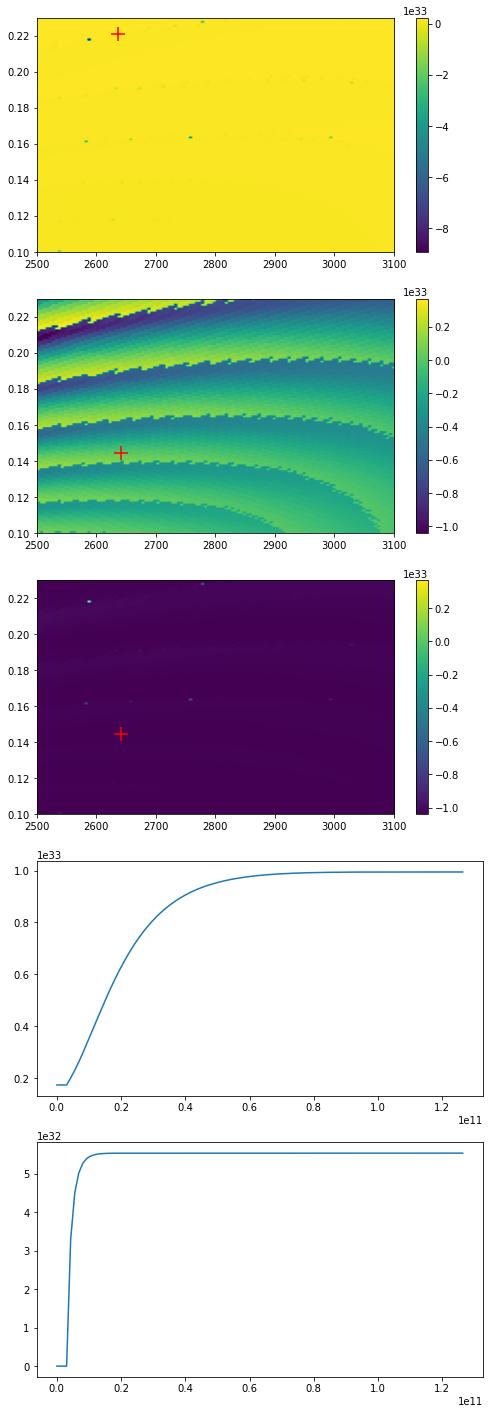

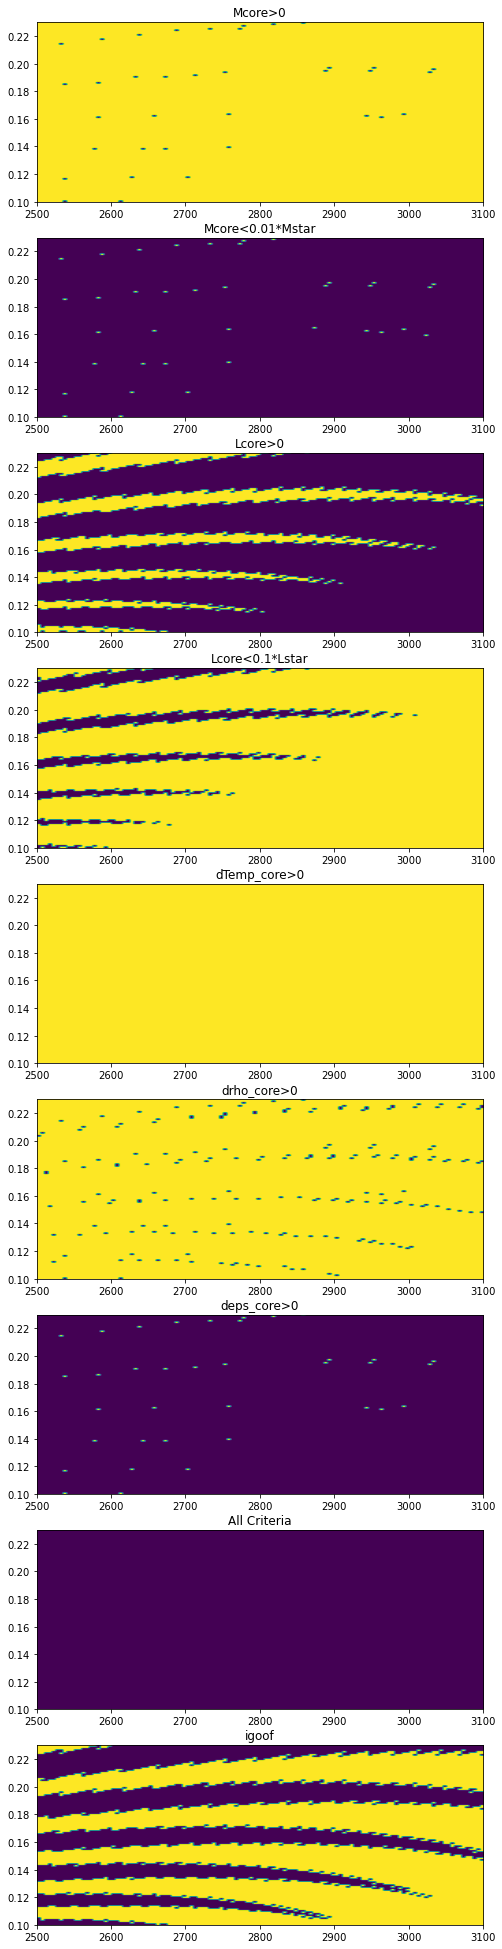

In [44]:
analyzeresults(data)

# Trying curve_fit

In [7]:
def starmodel_func(x,*pars):
    lum,teff = pars
    Igoof,ierr,istop,tab = starmodel(0.5,lum,teff,0.70,0.008,verbose=False)
    nx = len(x)
    resid = np.zeros(nx,float)
    # core mass, target is 0.005 * total mass
    resid[0] = tab['M'][-1] - tab['M'][0]*0.005
    resid[0] /= tab['M'][0]   # normalize by total mass
    # core luminosity, target is 0.05 * total luminosity
    resid[1] = tab['L'][-1] - tab['L'][0]*0.05
    resid[1] /= tab['L'][0]
    # core temperature, target is 0.05 * total luminosity
    if nx>2:
        dTeff = tab['T'][-1] - tab['T'][-2]
        resid[2] = dTeff - tab['T'][-2]*0.1
        resid[2] /= tab['T'][-2]    # normalize
    # core density, target is a difference of 0.1*shell2
    drho = tab['rho'][-1] - tab['rho'][-2]
    if nx>3:
        resid[3] = drho - tab['rho'][-2]*0.1
        resid[3] /= tab['rho'][-2]  # normalize
    # core epsilon, target is 0.05 * total luminosity
    deps = tab['epsilon'][-1] - tab['epsilon'][-2]
    if nx>4:
        resid[4] = deps - tab['epsilon'][-2]*0.1
        resid[4] /= tab['epsilon'][-2]   # normalize
    
    #print(pars)
    #print(resid)
    
    return resid

In [29]:
init0 = [0.2,3000.]
x = np.zeros(2,float)
y = np.zeros(2,float)
pars,cov = curve_fit(starmodel_func,x,y,p0=init0)
print(pars)

 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  536
 with the following conditions:
T =  -74042114.64528151  K
P =  8.039227583882676e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  536
 with the following conditions:
T =  -74042114.64528151  K
P =  8.039227583882676e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 I

In [35]:
init0 = pars
init0 = [0.2,3000.]
x = np.zeros(5,float)
y = np.zeros(5,float)
pars2,cov2 = curve_fit(starmodel_func,x,y,p0=init0)
print(pars2)

 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  536
 with the following conditions:
T =  -74042114.64528151  K
P =  8.039227583882676e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  536
 with the following conditions:
T =  -74042114.64528151  K
P =  8.039227583882676e+17  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 I

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in double_scalars
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in double_scalars


[4.97533013e-02 2.86473024e+03]


In [31]:
Igoof,ierr,istop,tab = starmodel(0.8,pars[0],pars[1],0.70,0.008)

Sorry to be the bearer of bad news, but...
       Your model has some problems
You created a star with a hole in the center!

***** The integration has been completed *****
      The model has been stored in starmodl_py.dat



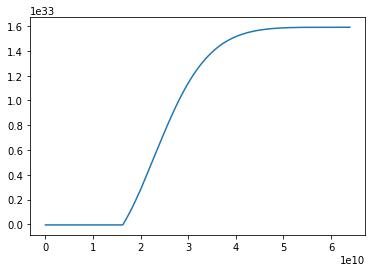

In [32]:
plt.plot(tab['r'],tab['M'])

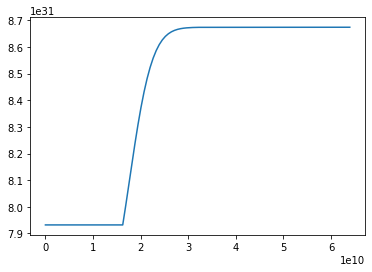

In [33]:
plt.plot(tab['r'],tab['L'])

In [745]:
# 2.83416433e-01 4.20436852e+03
data = gridsearch([0.8,0.70,0.008],[0.283416-0.02,0.283416+0.02],[4204.36-3,4204.36+3],nlum=100,nteff=100)

Search grid is  100  x  100
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  433
 with the following conditions:
T =  -3.871772284756511e+30  K
P =  1.2844421655919702e+42  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again with different
 initial conditions.
 In case it helps, I detected the problem in zone  433
 with the following conditions:
T =  -4.303512005440892e+29  K
P =  1.4372706705275042e+41  dynes/cm**2
 Something is a little wrong here.
 You are asking me to deal with either a negative temperature
 or a negative pressure.  I am sorry but that is not in my
 contract! You will have to try again 

Mass results
------------
Min M0= -2.830549578407452e+30
Max M0= 1.865255692701359e+31
Min |M0|= 6.279275291416669e+26
Best index =  (16, 40)
Best Luminosity= 0.26988064646464643
Best Temperature= 4203.784242424242
 
Luminosity results
------------
Min M0= -4.523341023718394e+30
Max M0= 1.0220841881711941e+32
Min |M0|= 8.812595102025418e+27
Best index =  (0, 62)
Best Luminosity= 0.263416
Best Temperature= 4205.117575757576
 
Best index =  (16, 40)
Best Luminosity= 0.26988064646464643
Best Temperature= 4203.784242424242
igoof=0 3
[0.27028469 0.27068873 0.27109277]
[4201.36       4204.08727273 4206.69333333]


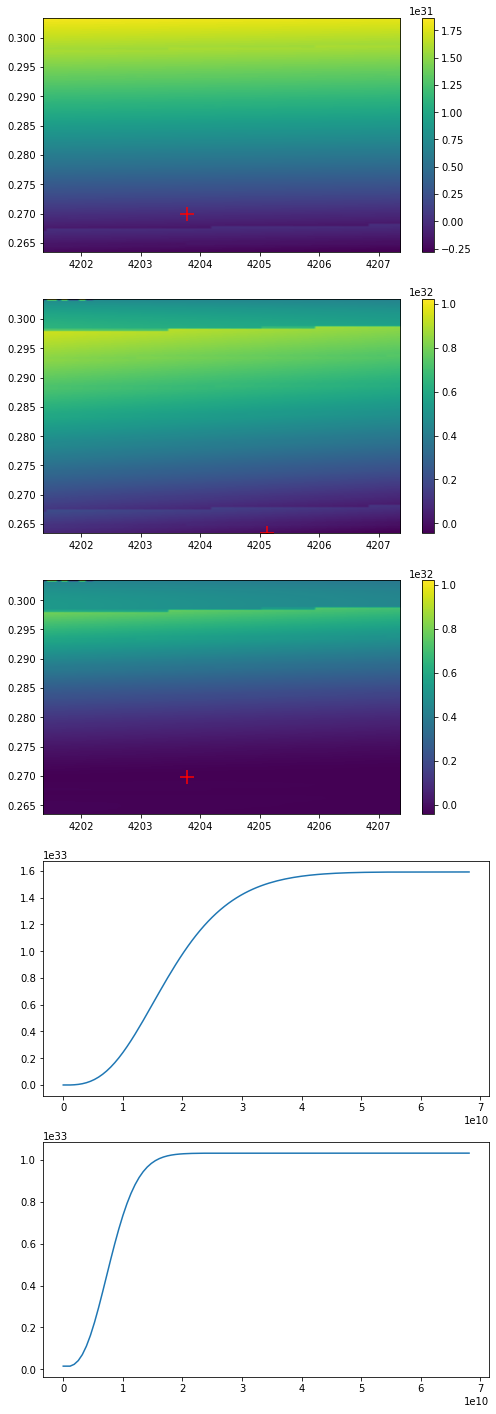

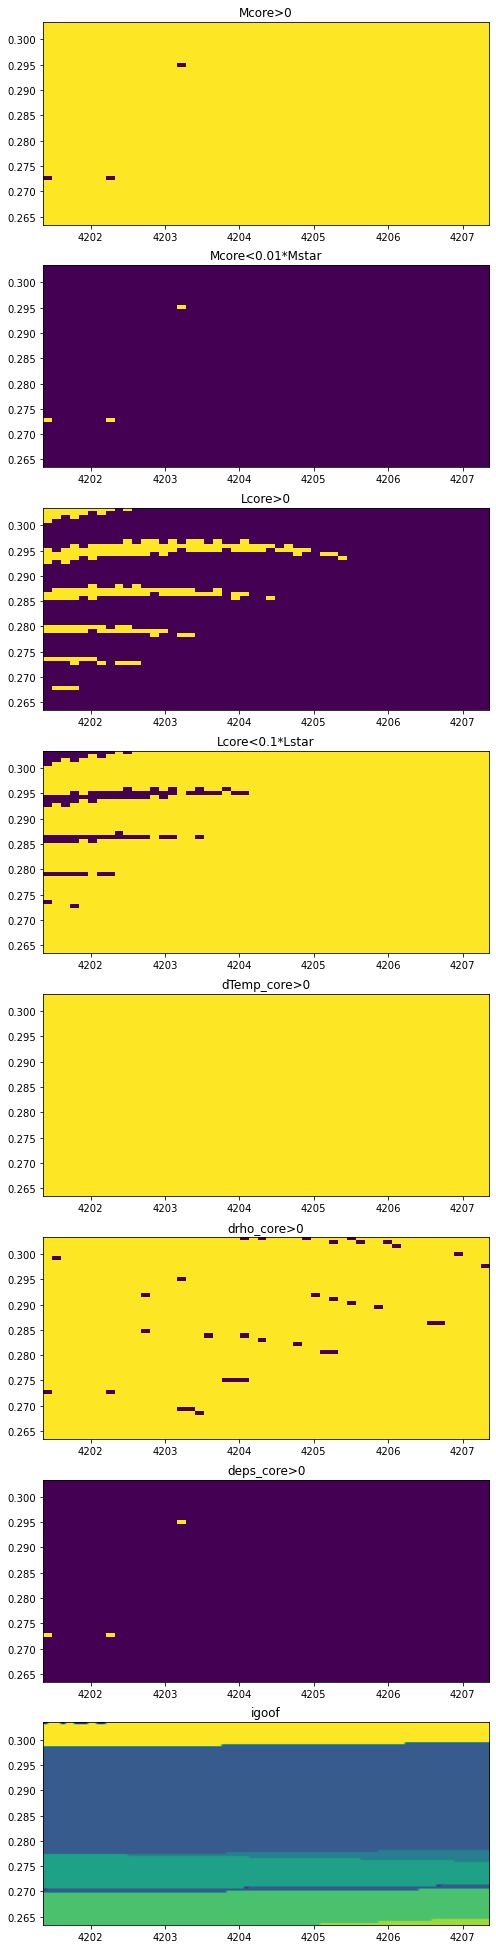

In [751]:
analyzeresults(data)

In [752]:
Igoof,ierr,istop,tab = starmodel(0.8,0.27068873,4204.08727273,0.70,0.008)

CONGRATULATIONS, I THINK YOU FOUND IT!
However, be sure to look at your model carefully.

***** The integration has been completed *****
      The model has been stored in starmodl_py.dat

